<a href="https://colab.research.google.com/github/zahidjkuai/3D-CNN/blob/main/explanation_of_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from transformers import CLIPTokenizer  # Tokenizer for the CLIP model, converts text into tokens
from transformers import CLIPProcessor  # Preprocessor for CLIP model, handles image/text preprocessing
from transformers import CLIPModel      # CLIP model for image-text embedding and similarity tasks
import os
import torch                            # PyTorch library, used for tensor operations and GPU computations
import torch.nn.functional as F         # Contains functional API for neural network operations (e.g., activations, loss functions)
import numpy as np                      # Numerical library for array manipulation and computations
import matplotlib.pyplot as plt         # Library for plotting images and visualizations
import seaborn as sns                   # Library for creating statistical visualizations

from PIL import Image                   #used for loading and processing images
import requests                         #used for fetch images from URL
from io import BytesIO                  #enables reading binary data as file-like objects in memory


**Load Model**

In [ ]:
#Define the model name for the CLIP variant (Vision Transformer - base, 32x32 patches)
model_name = "openai/clip-vit-base-patch32"
#load pre-trained CLIP model from Hugging Face
model = CLIPModel.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

**Tockenize Text Strings**
First convert text strings into tockens. A Tocken is a numerical representation of a word. When a string is tockenized it is padded with start and end tockens.

In [ ]:
#Load the tockenizer associated with the specified CLIP Model
tokenizer = CLIPTokenizer.from_pretrained(model_name)
#Define a list of text description to embed
text = [" a dog", "a dragon", "a tiger", "a cat"]
#Tockenize and preprocess the text inputs with padding to ensure equal sequence lengths
inputs = tokenizer(text, padding=True, return_tensors = "pt")

#unpack the inputs
inputs_ids = inputs.input_ids #tokenized and encoded text input IDs
#print information of the unpacked inputs
print("Input IDs (shape):", inputs_ids.shape)
print(inputs_ids)


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Input IDs (shape): torch.Size([4, 4])
tensor([[49406,   320,  1929, 49407],
        [49406,   320,  5471, 49407],
        [49406,   320,  6531, 49407],
        [49406,   320,  2368, 49407]])


**Find Text Embeddings**

In [ ]:
#compute the embeddings without tracking gradients (inference mode)
with torch.no_grad():
  #obtain text embeddings (feature vectors) from the CLIP model
  text_embeddings = model.get_text_features(**inputs)
#print the shape of the resulting text embeddings tensor
#the shape is [number_of_texts, embedding_dimension]
print(text_embeddings.shape)

torch.Size([4, 512])


# 6.󠀠󠀮󠁽󠁝󠁝󠁝󠁝 Calculate Cosine Similarity


---


*Why did the two vectors start dating after math class?*

*Because when they calculated their cosine similarity, they realized they were practically aligned—it was love at first dot-product!*


---



**Cosine similarity** measures how similar (aligned) two vectors are by looking only at the angle between them, not their length.

* Imagine each vector as an arrow from the origin.
* The cosine of the angle \$\theta\$ between the arrows is

$$
\operatorname{cosine\_sim}(\mathbf{a}, \mathbf{b}) \;=\; \cos(\theta) \;=\;
\frac{\mathbf{a}\cdot\mathbf{b}}
     {\lVert\mathbf{a}\rVert\,\lVert\mathbf{b}\rVert}
$$

* A value of **+1** means the arrows point in exactly the same direction (perfect similarity), **0** means they’re orthogonal (no similarity), and **–1** means they point in opposite directions (complete dissimilarity).

Because it ignores magnitude, cosine similarity is ideal for comparing text or image embeddings where direction captures meaning and length may just scale with word count or pixel intensity.

The calculated cosine similarity between strings are displayed using a color coded matrix.

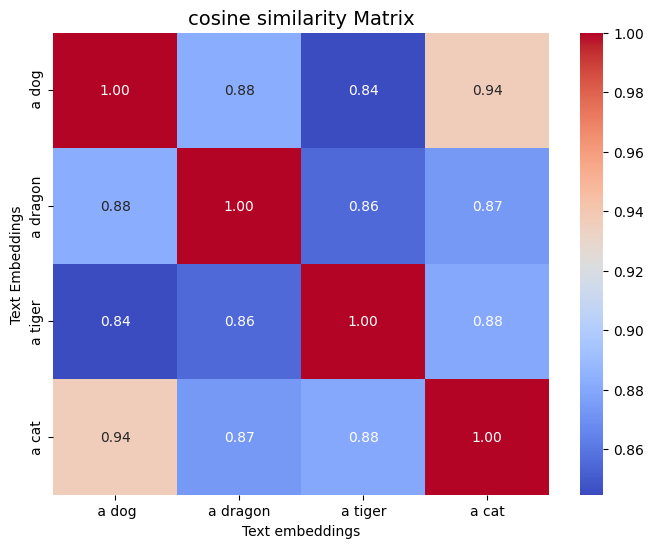

In [ ]:
# Text_embeddings is a tensor of shape [n, d], where:
# - n = number of text prompts
# - d = embedding dimension

# Compute the n x n cosine similarity matrix between all pairs of embeddings
# text_embeddings[:, None, :] reshapes embeddings to [n, 1, d]
# text_embeddings[None, :, :] reshapes embeddings to [1, n, d]
# cosine_similarity calculates similarity along the last dimension (d)
cosine_similarity = F.cosine_similarity(
    text_embeddings[:, None, :],  #shape: [n,1,d]
    text_embeddings[None, :, :],  #shape [1,n,d]
    dim = 2                       # calculate similarity along embedding dimension d
).cpu().numpy()                   #Move to cpu and convert tensor to Numpy array for plotting

#initialize a matplotlib figure with specified size (width=6,height=4)
plt.figure(figsize=(8,6))
#create a heatmap visualization using seaborn to display the cosine similarity matrix
sns.heatmap(
    cosine_similarity,      #matrix to visualize (n x n similarity scores)
    annot = True,            #annote each cell with numeric similarity value
    fmt = ".2f",            # format annotations to two decimal places
    cmap = "coolwarm",
    xticklabels= text,
    yticklabels=text
)

#set the plot title with font size 14
plt.title("cosine similarity Matrix", fontsize = 14)
plt.xlabel("Text embeddings")
plt.ylabel("Text Embeddings")
plt.show()


**Plot Images**

In [ ]:
 # Utility function for displaying images with labels
def plot_images(images, labels):
  n = len(images)                        # Number of images loaded successfully
  fig, axes = plt.subplots(1, n)         # Create subplots with one row and n columns
  # Loop through each subplot axis, image, and its label to display them
  for ax, img, lbl in zip(axes, images, labels):
      ax.imshow(img)                     # Display the image on the axis
      ax.set_title(lbl)                  # Set the title of the subplot to the image label
      ax.axis("off")

  plt.tight_layout()                     # Adjust layout to prevent overlap
  plt.show()                             # Show the image plot

**Load and Display Images**

In [ ]:
#Load a pre-trained CLIP processor for handling images and text preprocessing
processor = CLIPProcessor.from_pretrained(model_name)

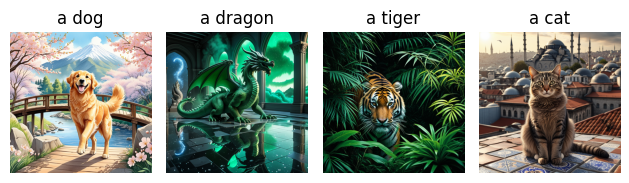

In [ ]:
# Dictionary containing labels and their corresponding image
image_paths = {
    "a dog": "/content/dog.png",
    "a dragon": "/content/dragon.png",
    "a tiger": "/content/tiger.png",
    "a cat": "/content/cat.png"
}

# Define a function to load images from local files
def load_local_image(file_path):
    # Check if the file actually exists at the given path
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Local image file not found at: {file_path}")

    # Open the local image file, convert it to RGB format, and return the PIL Image
    return Image.open(file_path).convert("RGB") #

# Initialize empty lists for successfully loaded images and their labels
images = []
loaded_labels = [] # Create a new list to track only the successful labels

# Loop through each label to load the associated image
for label, path in image_paths.items():
    try:
        # Use the new function for local files
        img = load_local_image(path)
        images.append(img)
        loaded_labels.append(label) # Only append label if image loaded successfully
    except FileNotFoundError as e:
        # If an image fails to load, print an error message
        print(f"Failed to load {label}: {e}")

if images:
    plot_images(images, loaded_labels)
else:
    print("No images were successfully loaded to display.")

**Calculate Image Embeddings & Display Similarity**

torch.Size([4, 512])


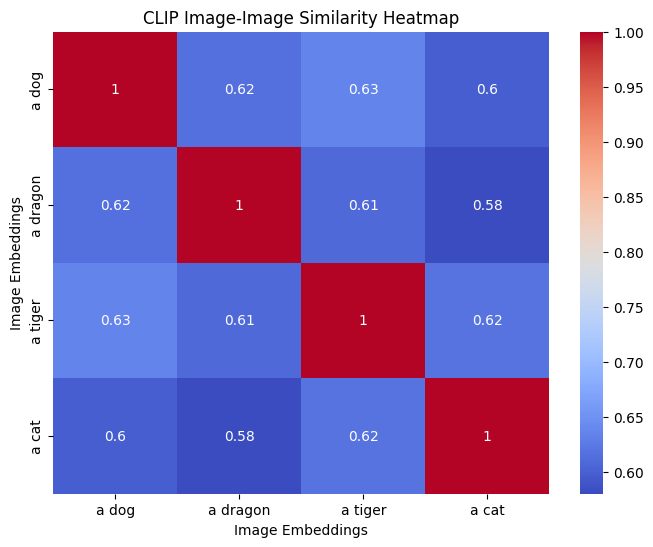

In [ ]:
# Preprocess images using CLIP processor to prepare for embedding generation
image_inputs = processor(images=images, return_tensors="pt")

with torch.no_grad():
  # Generate image embeddings using the CLIP model
  image_embeddings = model.get_image_features(**image_inputs)

# Print the shape of the resulting image embeddings tensor
# The shape is [number_of_images, embedding_dimension]
print(image_embeddings.shape)

# Compute similarity matrix
img_similarity = F.cosine_similarity(image_embeddings[:, None, :], image_embeddings[None, :, :], dim=2).cpu().numpy()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(img_similarity, annot=True, xticklabels=labels, yticklabels=labels, cmap="coolwarm")
plt.xlabel("Image Embeddings")
plt.ylabel("Image Embeddings")
plt.title("CLIP Image-Image Similarity Heatmap")
plt.show()

**Calculate Image-Text Similarity**

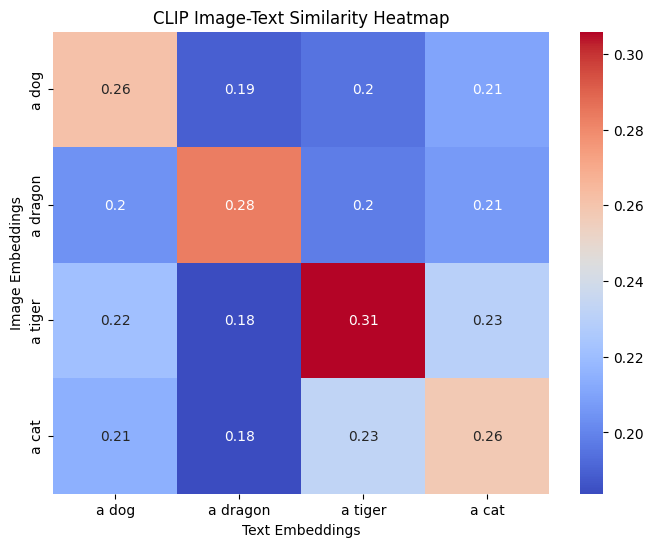

In [ ]:
# Compute similarity matrix
txt_image_similarity = F.cosine_similarity(text_embeddings[:, None, :], image_embeddings[None, :, :], dim=2).cpu().numpy()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(txt_image_similarity, annot=True, xticklabels=labels, yticklabels=labels, cmap="coolwarm")
plt.xlabel("Text Embeddings")
plt.ylabel("Image Embeddings")
plt.title("CLIP Image-Text Similarity Heatmap")
plt.show()

In [3]:
python clean_notebook.py explanation_of_Embeddings.ipynb

SyntaxError: invalid syntax (ipython-input-1177579154.py, line 1)